In [17]:
# %load extractPatches.py
import cv2
from cv2 import moments,HuMoments
import pickle
import numpy as np

def create_footprint(cell_size=41):
    center=(cell_size-1)/2.
    footprint=np.ones([cell_size,cell_size])>1

    for i in range(cell_size):
        for j in range(cell_size):
            footprint[i,j]=((i-center)**2+(j-center)**2)<=center**2
            
    ratio=sum(footprint.flatten())/(cell_size**2) # ratio of footprint area to square patch area
    return cell_size,center,ratio,footprint

def normalize_greyvals(ex):
    ex=ex*mask
    _flat=ex.flatten()
    _m=np.mean(_flat)/ratio
    _m2=np.mean(_flat**2)/ratio
    print(_m.shape,_m2.shape,_flat.shape)
    if _m2>_m**2:
        _std=np.sqrt(_m2-_m**2)
    else:
        _std=0.1
    print('normalize_greyvals: mean=',_m,'std=',_std)
    ex_new=(ex-_m)/_std
    return _m,_std,ex_new * mask

def angle(ex):
    rows,cols = ex.shape
    M=moments(ex+mask)
    #print(M['m00'],M['m10'],M['m01'])
    x=M['m10']/M['m00']
    y=M['m01']/M['m00']
    nu20=(M['m20']/M['m00'])-x**2
    nu02=(M['m02']/M['m00'])-y**2
    nu11=(M['m11']/M['m00'])-y*x
    ang_est=-np.arctan(2*nu11/(nu20-nu02))/np.pi+0.5

    if ang_est>0.5:
        ang_est-=1
    ang180=(ang_est+(np.sign(nu11))/2)*90

    if ang180>=180:
        ang180-=360
    if ang180<-180:
        ang180+=360
    return ang180

def flipOrNot(ex):
    rows,cols = ex.shape
    M=moments(ex)
    x=M['m10']/M['m00'] - cols/2.
    y=M['m01']/M['m00'] - rows/2.
    if abs(x)>abs(y):
        return x<0
    else:
        return y<0


def normalize_angle(ex):
    rows,cols = ex.shape
    ang=angle(ex)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-ang,1)
    dst= cv2.warpAffine(ex,M,(cols,rows))*footprint*1
    if flipOrNot(dst):
        M180 = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
        dst = cv2.warpAffine(dst,M180,(cols,rows))

    return ang,dst*footprint*1.

from astropy.convolution import MexicanHat2DKernel,convolve
mexicanhat_2D_kernel = 10000*MexicanHat2DKernel(10)

def find_threshold(image,percentile=0.9):
    V=sorted(image.flatten())
    l=len(V)
    thr=V[int(l*percentile)] #consider only peaks in the top 5%
    return thr

def normalize(window,range=[0,1],dtype=np.float32):
    _max=max(window.flatten())
    _min=min(window.flatten())
    return np.array((window-_min)/(_max-_min),dtype=dtype)

from photutils.detection import find_peaks

def extract_patches(_mean,Peaks):
    markers=_mean*np.float32(0)
    stamp=footprint*np.float32(0.2)

    X=list(Peaks["x_peak"])
    Y=list(Peaks["y_peak"])

    extracted=[]
    for i in range(len(X)):
        corner_x=np.uint16(X[i]-center)
        corner_y=np.uint16(Y[i]-center)

        # ignore patches that extend outside of window
        if(corner_x<0 or corner_y<0 or \
           corner_x+cell_size>markers.shape[1] or corner_y+cell_size>markers.shape[0]):
            continue

        # mark location of extracted patches
        markers[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size]=stamp
        # extract patch
        ex=np.array(_mean[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size])
        ex *= mask

        #normalize patch interms of grey values and in terms of rotation
        _m,_std,ex_grey_normed=normalize_greyvals(ex)
        rot_angle1,ex_rotation_normed=normalize_angle(ex_grey_normed)
        rot_angle2,ex_rotation_normed=normalize_angle(ex_rotation_normed)
        extracted.append((_m,_std,rot_angle1+rot_angle2,ex_rotation_normed*mask))
    return extracted,markers
    

def preprocess(window):
    _mean=normalize(np.mean(window,axis=2))
    P=convolve(_mean,mexicanhat_2D_kernel)
    thr=find_threshold(P,0.9)
    Peaks=find_peaks(P,thr,footprint=footprint)
    return _mean,P,Peaks

In [18]:
import pickle
window=pickle.load(open('../../data/window_10780_21934.pkl','rb'))
cell_size,center,ratio,footprint=create_footprint(cell_size=60)
mask=1.*footprint
_mean,P,Peaks=preprocess(window)    
print('found',len(Peaks),'patches')
extracted,markers=extract_patches(_mean,Peaks)


pickle.dump(extracted,open('../../data/extracted.pkl','wb'))

found 219 patches
() () (3600,)
normalize_greyvals: mean= 0.10622736059947051 std= 0.07124584207298962
() () (3600,)
normalize_greyvals: mean= 0.11123008372893942 std= 0.0928522740975313
() () (3600,)
normalize_greyvals: mean= 0.14145205239526018 std= 0.06849969127097659
() () (3600,)
normalize_greyvals: mean= 0.16117333523449098 std= 0.17427961801462455
() () (3600,)
normalize_greyvals: mean= 0.1983237185634443 std= 0.09845950950735259
() () (3600,)
normalize_greyvals: mean= 0.12382071834842559 std= 0.09517218262409192
() () (3600,)
normalize_greyvals: mean= 0.20806579909146533 std= 0.11601093642876018
() () (3600,)
normalize_greyvals: mean= 0.15903120739836787 std= 0.09380389165389878
() () (3600,)
normalize_greyvals: mean= 0.1936550661005222 std= 0.11119426919000248
() () (3600,)
normalize_greyvals: mean= 0.16424110360996094 std= 0.09298919745437231
() () (3600,)
normalize_greyvals: mean= 0.12802191892236733 std= 0.08512783916211428
() () (3600,)
normalize_greyvals: mean= 0.22483324

() () (3600,)
normalize_greyvals: mean= 0.24001184367081052 std= 0.12073486532767534
() () (3600,)
normalize_greyvals: mean= 0.23975496131806426 std= 0.12711753343607748


In [6]:
!ls -lh ../../data/window_10780_21934.pkl

-rw-r--r--  1 yoavfreund  staff   5.6M Aug 26 11:33 ../../data/window_10780_21934.pkl


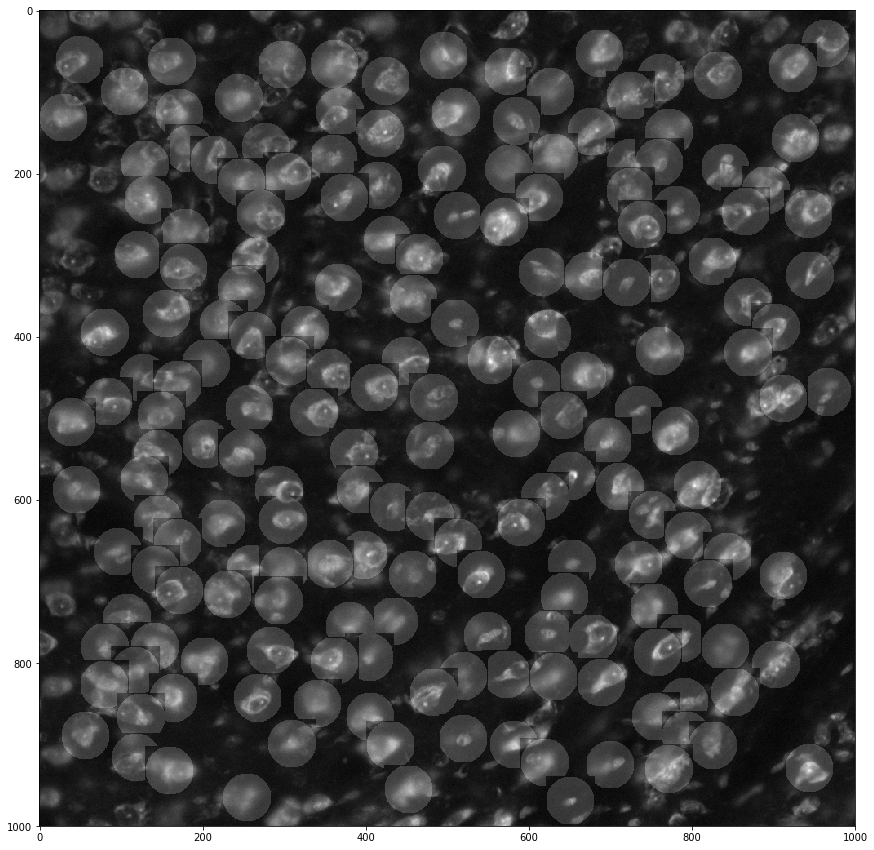

In [6]:
figure(figsize=[15,15])
imshow(markers+_mean,cmap='gray')

In [3]:
!ls -lh ../data/*.pkl

-rw-r--r--  1 yoavfreund  staff   3.1M Aug 12 17:59 ../data/extracted.pkl
-rw-r--r--  1 yoavfreund  staff   5.7M Jul  1 20:46 ../data/window.pkl


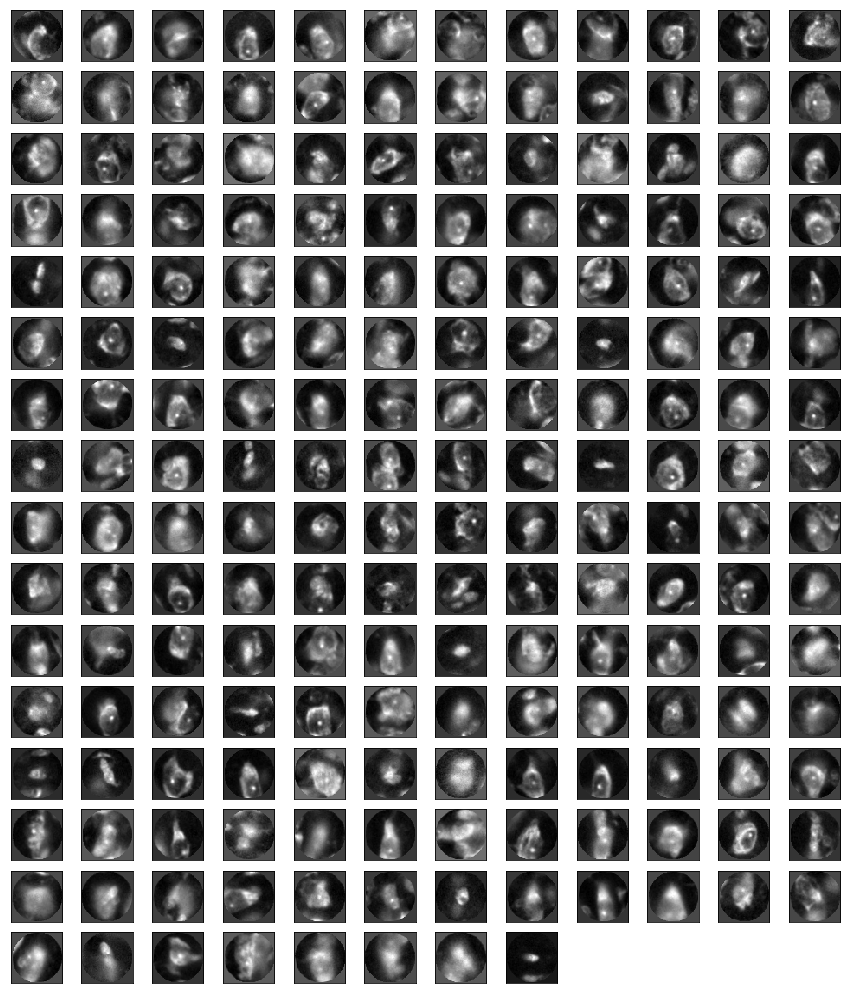

In [7]:
figure(figsize=(15,36))
for i in range(len(extracted)):
    subplot(32,12,i+1);
    fig=imshow(extracted[i][-1],cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

-0.9521937846790202 25.391443066494535 3.07653153123963


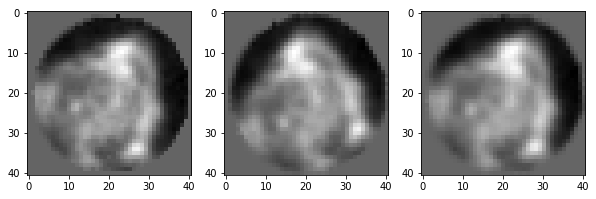

In [6]:

_m,_std,_ang,ex=extracted[15]
rows,cols = ex.shape
ang=angle(ex)
rotate=30
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
dst= cv2.warpAffine(ex,M1,(cols,rows))
correction=angle(dst)-ang
M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-correction,1)
restored = cv2.warpAffine(dst,M2,(cols,rows))
if flipOrNot(restored):
    M180 = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
    restored = cv2.warpAffine(restored,M180,(cols,rows))
res_angle=angle(restored)

print(ang,correction,res_angle)

figure(figsize=[10,4])
subplot(1,3,1)
imshow(ex,cmap='gray')
subplot(1,3,2)
imshow(dst,cmap='gray')
subplot(1,3,3)
imshow(restored,cmap='gray');

30 31.40985054037378 -2.0621389322093715 -2.0621389322093715 -0.00880184512229265


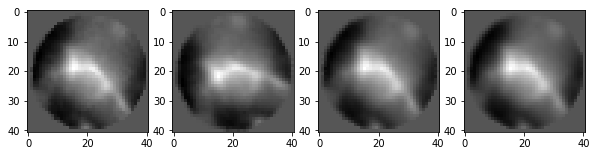

In [7]:
_m,_std,_ang,ex=extracted[12]
rotate=30
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
rotated= cv2.warpAffine(ex,M1,(cols,rows))

ang,dst=normalize_angle(rotated)
corrected=angle(dst)
ang2,dst2=normalize_angle(dst)
corrected2=angle(dst2)

print(rotate,ang,corrected,ang2,corrected2)
figure(figsize=[10,4])
subplot(1,4,1)
imshow(ex,cmap='gray')
subplot(1,4,2)
imshow(rotated,cmap='gray')
subplot(1,4,3)
imshow(dst,cmap='gray')
subplot(1,4,4)
imshow(dst2,cmap='gray')

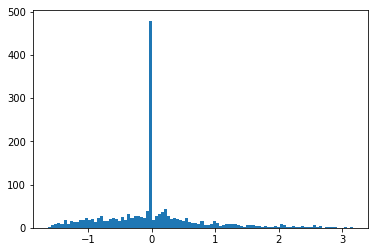

In [8]:

hist(ex.flatten(),bins=100);

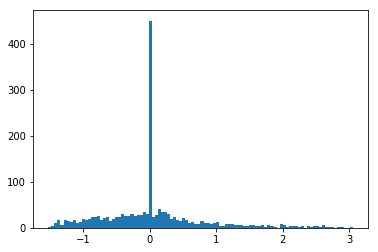

In [9]:
hist(dst2.flatten(),bins=100);

In [10]:
sum(footprint)

1257